# Semantic Segmentation using InceptionRestnetV2 and UNET

Mount Google Drive

In [11]:
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Import Libraries

In [12]:
## Libraries

import os
import numpy as np
import random
import cv2
from tqdm.notebook import tqdm
import tensorflow
from glob import glob
import io

from keras import backend as K
from skimage.transform import resize
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras import Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Conv2DTranspose, \
                         concatenate, Input, Dropout
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from albumentations import CenterCrop, RandomRotate90, GridDistortion, HorizontalFlip, VerticalFlip, RandomBrightnessContrast

### (Zipped) Dataset upload using Drive
https://towardsdatascience.com/how-to-successfully-add-large-data-sets-to-google-drive-130beb320f1a



*   Create a shortcut in MyDrive from Sharedwithme folder in Google Drive



In [13]:
!unzip gdrive/My\ Drive/A3_Dataset.zip

Archive:  gdrive/My Drive/A3_Dataset.zip
replace A3_Dataset/dataset1/annotations_prepped_test/0016E5_07959.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


### Display Original Image and Ground Truth Segmented Mask

(360, 480, 3)


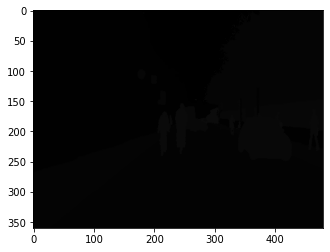

In [15]:
im=cv2.imread("/content/A3_Dataset/dataset1/annotations_prepped_test/0016E5_07959.png")
print(im.shape)
imgplot = plt.imshow(im)
plt.savefig("annotations_prepped_test.png")

(360, 480, 3)


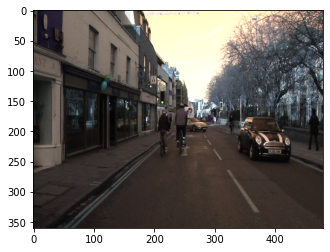

In [16]:
im=cv2.imread("/content/A3_Dataset/dataset1/images_prepped_test/0016E5_07959.png")
print(im.shape)
imgplot = plt.imshow(im)
plt.savefig("images_prepped_test.png")

# Load Dataset

## Data Augmentation
https://github.com/nikhilroxtomar/Data-Augmentation-for-Semantic-Segmentation-Dataset

In [18]:
 def load_data(path):
    images = sorted(glob(os.path.join(path, "images_prepped_train/*")))
    masks = sorted(glob(os.path.join(path, "annotations_prepped_train/*")))
    images_test = sorted(glob(os.path.join(path, "images_prepped_test/*")))
    masks_test = sorted(glob(os.path.join(path, "annotations_prepped_test/*")))
    return images, masks, images_test, masks_test
    
path = "/content/A3_Dataset/dataset1/"
images, masks, images_test, masks_test = load_data(path)
print(f"Original Images: {len(images)} - Original Masks: {len(masks)}")
print(f"Test Images: {len(images_test)} - Test Masks: {len(masks_test)}")

Original Images: 367 - Original Masks: 367
Test Images: 101 - Test Masks: 101


In [19]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

""" Creating folders. """
create_dir("new_data/images")
create_dir("new_data/masks")

In [20]:
def augment_data(images, masks, save_path, augment=True):
    H = 128
    W = 128

    for x, y in tqdm(zip(images, masks), total=len(images)):
        name = x.split("/")[-1].split(".")
        """ Extracting the name and extension of the image and the mask. """
        image_name = name[0]
        image_extn = name[1]

        name = y.split("/")[-1].split(".")
        mask_name = name[0]
        mask_extn = name[1]

        """ Reading image and mask. """
        x = cv2.imread(x, cv2.IMREAD_COLOR)
        y = cv2.imread(y, cv2.IMREAD_COLOR)

        """ Augmentation """
        if augment == True:

            aug = RandomRotate90(p=1.0)
            augmented = aug(image=x, mask=y)
            x = augmented['image']
            y = augmented['mask']

            aug = HorizontalFlip(p=1.0)
            augmented = aug(image=x, mask=y)
            x1 = augmented['image']
            y1 = augmented['mask']


            aug = RandomBrightnessContrast(p=0.2)
            augmented = aug(image=x, mask=y)
            x2 = augmented['image']
            y2 = augmented['mask']


            save_images = [x, x1, x2]
            save_masks =  [y, y1, x2]

        else:
            save_images = [x]
            save_masks = [y]

        """ Saving the image and mask. """
        idx = 0
        for i, m in zip(save_images, save_masks):
            i = cv2.resize(i, (W, H))
            m = cv2.resize(m, (W, H))

            if len(images) == 1:
                tmp_img_name = f"{image_name}.{image_extn}"
                tmp_mask_name = f"{mask_name}.{mask_extn}"
            else:
                tmp_img_name = f"{image_name}_{idx}.{image_extn}"
                tmp_mask_name = f"{mask_name}_{idx}.{mask_extn}"

            image_path = os.path.join(save_path, "images", tmp_img_name)
            mask_path = os.path.join(save_path, "masks", tmp_mask_name)

            cv2.imwrite(image_path, i)
            cv2.imwrite(mask_path, m)

            idx += 1


""" Applying data augmentation. """
augment_data(images, masks, "new_data", augment=True)

  0%|          | 0/367 [00:00<?, ?it/s]

In [21]:
def load_augmented_data(path):
  images = sorted(glob(os.path.join(path, "images/*")))
  masks = sorted(glob(os.path.join(path, "masks/*")))
  return images, masks
    
""" Loading augmented images and masks. """
images, masks = load_augmented_data("new_data/")
print(f"Augmented Images: {len(images)} - Augmented Masks: {len(masks)}")


Augmented Images: 1101 - Augmented Masks: 1101


### Display Augmented Image and Mask

(128, 128, 3)


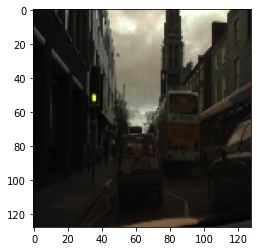

In [22]:
im=cv2.imread("/content/new_data/images/0001TP_006690_0.png")
print(im.shape)
imgplot = plt.imshow(im)
plt.savefig("augmented_image.png")

(128, 128, 3)


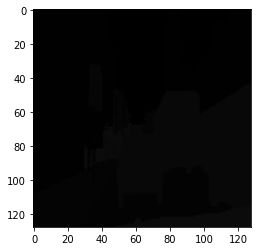

In [23]:
im=cv2.imread("/content/new_data/masks/0001TP_006690_0.png")
print(im.shape)
imgplot = plt.imshow(im)
plt.savefig("augmented_mask.png")

## Create Labelled Dataset

Train and Validation

In [26]:
IM_HEIGHT=128
IM_WIDTH=128
## Get empty numpy arrays TRAIN
X = np.zeros((len(images), IM_HEIGHT, IM_WIDTH, 3), dtype=np.float32)
y = np.zeros((len(masks), IM_HEIGHT, IM_WIDTH, 3), dtype=np.float32)

## Get empty numpy arrays TEST
X_label = np.zeros((len(images_test), IM_HEIGHT, IM_WIDTH, 3), dtype=np.float32)
y_label = np.zeros((len(masks_test), IM_HEIGHT, IM_WIDTH, 3), dtype=np.float32)

print("X", X.shape)
print("y", y.shape)

print("X_label", X_label.shape)
print("y_label", y_label.shape)


X (1101, 128, 128, 3)
y (1101, 128, 128, 3)
X_label (101, 128, 128, 3)
y_label (101, 128, 128, 3)


In [27]:

def create_labelled_dataset():
   
    for n, ids in enumerate(tqdm(IMG_IDS)):        
        img = load_img(os.path.join(DATA_IMAGES, ids))
        x_img_arr = np.asarray((img))
        
        mask  = load_img(os.path.join(DATA_MASKS, ids))
        y_mask_arr = np.asarray(mask)
        X[n] = x_img_arr/255.0 
        y[n] = y_mask_arr/255.0
        
    return X, y

In [28]:
DATA_IMAGES='/content/new_data/images'
DATA_MASKS='/content/new_data/masks'
IMG_IDS = next(os.walk(DATA_IMAGES))[2]  # returns all the files in '/content/A3_Dataset/dataset1/images_prepped_train'

X, y = create_labelled_dataset()


  0%|          | 0/1101 [00:00<?, ?it/s]

In [29]:
## Train and Validation set
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

### Preprocess the train and valid "LABEL"

In [30]:
print("X_train", X_train.shape)
print("y_train", y_train.shape)

print("X_valid", X_valid.shape)
print("y_valid", y_valid.shape)

X_train (880, 128, 128, 3)
y_train (880, 128, 128, 3)
X_valid (221, 128, 128, 3)
y_valid (221, 128, 128, 3)


Convert the LABEL to categorical and take np.argmax

In [31]:
def convert_to_categorical(Y):
  
  Y = tensorflow.keras.utils.to_categorical(Y, num_classes=12)
  return Y

In [32]:
y_train = convert_to_categorical(y_train)
y_valid = convert_to_categorical(y_valid)


In [33]:
  print("y_train", y_train.shape)
  print("y_valid", y_valid.shape)

y_train (880, 128, 128, 3, 12)
y_valid (221, 128, 128, 3, 12)


In [34]:
def categorical_to_argmax(Y):
  
  Y = np.argmax(Y, axis=3 )
  return Y


In [35]:
y_train = categorical_to_argmax(y_train)
print("y_train", y_train.shape)

y_train (880, 128, 128, 12)


In [36]:
y_valid = categorical_to_argmax(y_valid)
print("y_valid", y_valid.shape)


y_valid (221, 128, 128, 12)


### Preprocess the test "LABEL"

In [37]:
LABEL_MASKS='/content/A3_Dataset/dataset1/annotations_prepped_test'
LABEL_MASK_IDS = next(os.walk(LABEL_MASKS))[2]  # returns all the files in '/content/A3_Dataset/dataset1/images_prepped_train'
LABEL_IMAGES='/content/A3_Dataset/dataset1/images_prepped_test'
LABEL_IMG_IDS = next(os.walk(LABEL_IMAGES))[2]

for n, ids in enumerate(tqdm(LABEL_IMG_IDS)):        
        img = load_img(os.path.join(LABEL_IMAGES, ids))
        x_img_arr = np.asarray((img))
        x_img = resize(x_img_arr, (IM_HEIGHT, IM_WIDTH, 3), mode='constant', preserve_range=True)
        
        mask  = load_img(os.path.join(LABEL_MASKS, ids))
        y_mask_arr = np.asarray(mask)
        y_mask = resize(y_mask_arr, (IM_HEIGHT, IM_WIDTH, 3), mode='constant', preserve_range=True)
        X_label[n] = x_img/255.0 
        y_label[n] = y_mask/255.0

  0%|          | 0/101 [00:00<?, ?it/s]

In [38]:
print(X_label.shape)
print(y_label.shape)

(101, 128, 128, 3)
(101, 128, 128, 3)


Convert the LABEL to categorical and take np.argmax

In [39]:
#y_test lavel .to_categorical
y_test = convert_to_categorical(y_label)
print(y_test.shape)

#argmax of ylabel
y_test=categorical_to_argmax(y_test)
print(y_test.shape)

(101, 128, 128, 3, 12)
(101, 128, 128, 12)


# Create Model
https://github.com/qubvel/segmentation_models

In [40]:
! pip install -U segmentation-models

     |████████████████████████████████| 50 kB 5.5 MB/s 


Dice Coef as metric

In [41]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

In [46]:
import segmentation_models as sm
from tensorflow import keras
import time
keras.backend.set_image_data_format('channels_last')

BACKBONE = 'inceptionresnetv2'


# define model
model = sm.Unet(BACKBONE, input_shape=(128, 128, 3), classes=12, activation='softmax', encoder_weights=None, encoder_freeze=True, decoder_use_batchnorm=False)


model.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.001,amsgrad=True),
                   loss=tensorflow.keras.losses.CategoricalCrossentropy(), metrics=["accuracy",dice_coef, sm.metrics.precision,  sm.metrics.recall, sm.metrics.f1_score ])
start_time = time.time()
results = model.fit(X_train, y_train, batch_size=3,
                         verbose=1, epochs=5, 
                         validation_data=(X_valid, y_valid))
print("--- %s seconds ---" % (time.time() - start_time))

Epoch 1/5
294/294 [==============================] - 93s 243ms/step - loss: 3104264372839514112.0000 - accuracy: 0.5283 - dice_coef: 0.0083 - precision: 0.5138 - recall: 0.9311 - f1-score: 0.5141 - val_loss: 15662026367204065280.0000 - val_accuracy: 0.9633 - val_dice_coef: 0.0061 - val_precision: 0.8352 - val_recall: 0.9586 - val_f1-score: 0.8351
Epoch 2/5
294/294 [==============================] - 67s 228ms/step - loss: 42211812696832081920.0000 - accuracy: 0.9623 - dice_coef: 0.0066 - precision: 0.8357 - recall: 0.9495 - f1-score: 0.8357 - val_loss: 54525410542062927872.0000 - val_accuracy: 0.9633 - val_dice_coef: 0.0061 - val_precision: 0.8352 - val_recall: 0.9586 - val_f1-score: 0.8351
Epoch 3/5
294/294 [==============================] - 67s 229ms/step - loss: 71854223969207975936.0000 - accuracy: 0.9623 - dice_coef: 0.0066 - precision: 0.8357 - recall: 0.9502 - f1-score: 0.8357 - val_loss: 79217129972889026560.0000 - val_accuracy: 0.9632 - val_dice_coef: 0.0061 - val_precision: 0.

In [ ]:
# from keras.utils.vis_utils import plot_model
# plot_model(model, to_file='inceptionresnetv2.png')

In [ ]:
# model.summary()

Save the Model

### Plot Accuracy and Loss Curves

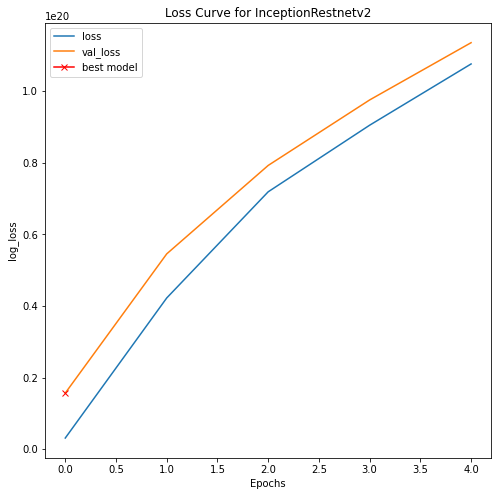

In [55]:

plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();
plt.title('Loss Curve for InceptionRestnetv2')
plt.savefig("Loss Curve InceptionRestnetv2.png")
plt.show()


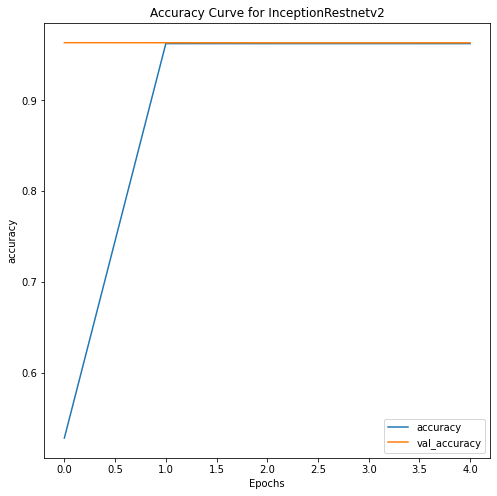

In [56]:

plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["accuracy"], label="accuracy")
plt.plot(results.history["val_accuracy"], label="val_accuracy")
# plt.plot( np.argmax(results.history["val_accuracy"]), np.max(results.history["val_accuracy"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.legend();
plt.title('Accuracy Curve for InceptionRestnetv2')
plt.savefig("Accuracy Curve InceptionRestnetv2.png")
plt.show()


# Evaluate the Model

In [60]:
model.evaluate(X_label, y_test)
start_time = time.time()
print("--- %s seconds ---" % (time.time() - start_time))

4/4 [==============================] - 1s 244ms/step - loss: 0.0000e+00 - accuracy: 0.9737 - dice_coef: 4.4823e-13 - precision: 0.8333 - recall: 1.0000 - f1-score: 0.8333
--- 0.00011324882507324219 seconds ---


### Display the Predictions

In [59]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps


val_preds = model.predict(X_valid[:100,...])



Input Image


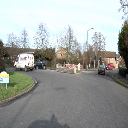

ground-truth target mask


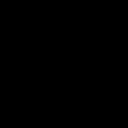

mask predicted by our model


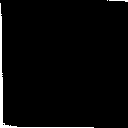

In [64]:

def display_mask_prediction(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)

def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(y_valid[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)

# Display results for validation image #10
i = 52

# Display input image
img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(X_valid[i]))
print("Input Image")
display(img)


# Display ground-truth target mask
print("ground-truth target mask")
display_mask(i)

# Display mask predicted by our model
print("mask predicted by our model")
display_mask_prediction(i)